# Spiral Geometry Analysis & Quality Labelling

This notebook analyzes the geometry metrics of generated spirals, labels them as 'clean' or 'messy', and visualizes the results.

## 1. Load Metrics

In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import sys
import os

# Add repo root to path
current_dir = Path(os.getcwd())
if current_dir.name == 'notebooks':
    repo_root = current_dir.parent
else:
    repo_root = current_dir

sys.path.append(str(repo_root))

metrics_path = repo_root / "results" / "spiral_metrics.csv"
if not metrics_path.exists():
    print(f"Error: {metrics_path} not found. Please run the geometry pipeline first.")
else:
    df = pd.read_csv(metrics_path)
    print(f"Loaded {len(df)} rows.")
    print("\nHead:")
    display(df.head())
    
    print("\nDescription:")
    cols = ["arm_count", "b_mean", "r2_mean", "fractal_dimension"]
    display(df[cols].describe())
    
    print("\nNaN counts:")
    print(df[cols].isna().sum())

Loaded 14 rows.

Head:


,image,arm_count,b_mean,b_std,r2_mean,fractal_dimension,fractal_dimension_ci_low,fractal_dimension_ci_high
0,controlled_00000.png,6.0,1.546270,0.448432,0.912547,1.352632,1.286975,1.296327
1,controlled_00001.png,2.0,2.739619,0.080028,0.613732,1.120007,1.034192,1.067030
2,controlled_00002.png,2.0,5.066407,0.004358,0.504200,1.181023,1.100616,1.135513
3,controlled_00003.png,3.0,1.225739,0.782152,0.846658,1.387894,1.312058,1.335578
4,controlled_00004.png,5.0,2.232108,0.804308,0.859064,1.377567,1.309121,1.325730



Description:


,arm_count,b_mean,r2_mean,fractal_dimension
count,14.000000,14.000000,14.000000,14.000000
mean,3.500000,2.603138,0.806686,1.330836
std,1.454436,0.919613,0.114676,0.140352
min,2.000000,1.225739,0.504200,1.068535
25%,2.000000,2.221377,0.788235,1.223925
50%,3.500000,2.597064,0.842643,1.382731
75%,4.000000,2.868231,0.867210,1.426502
max,6.000000,5.066407,0.917689,1.485080



NaN counts:
arm_count            0
b_mean               0
r2_mean              0
fractal_dimension    0
dtype: int64


## 2. Clean vs Messy Spiral Labelling

In [2]:
def label_spiral(row):
    arms = row["arm_count"]
    r2 = row["r2_mean"]
    D = row["fractal_dimension"]

    # Treat missing metrics as messy
    if pd.isna(arms) or pd.isna(r2) or pd.isna(D):
        return "messy", False

    # Clean: good arm count + good spiral fit + reasonable dimension
    if (arms in [2, 3, 4]
        and r2 >= 0.80
        and 1.1 <= D <= 1.5):
        return "clean", True

    # Borderline: some structure, but not perfect
    if (arms >= 1
        and r2 >= 0.6
        and 1.0 <= D <= 1.7):
        return "borderline", False

    # Everything else is messy
    return "messy", False

if 'df' in locals():
    df[["quality_label", "is_clean"]] = df.apply(lambda row: pd.Series(label_spiral(row)), axis=1)
    
    print("Quality Label Counts:")
    print(df["quality_label"].value_counts())
    
    print("\nMetrics by Label:")
    display(df.groupby("quality_label")[["r2_mean", "fractal_dimension"]].agg(["mean", "median"]))

Quality Label Counts:
quality_label
clean         7
borderline    6
messy         1
Name: count, dtype: int64

Metrics by Label:


r2_mean           fractal_dimension          
                   mean    median              mean    median
quality_label                                                
borderline     0.800307  0.818943          1.292226  1.365100
clean          0.855366  0.846658          1.385332  1.409531
messy          0.504200  0.504200          1.181023  1.181023

## 3. Metric Distributions

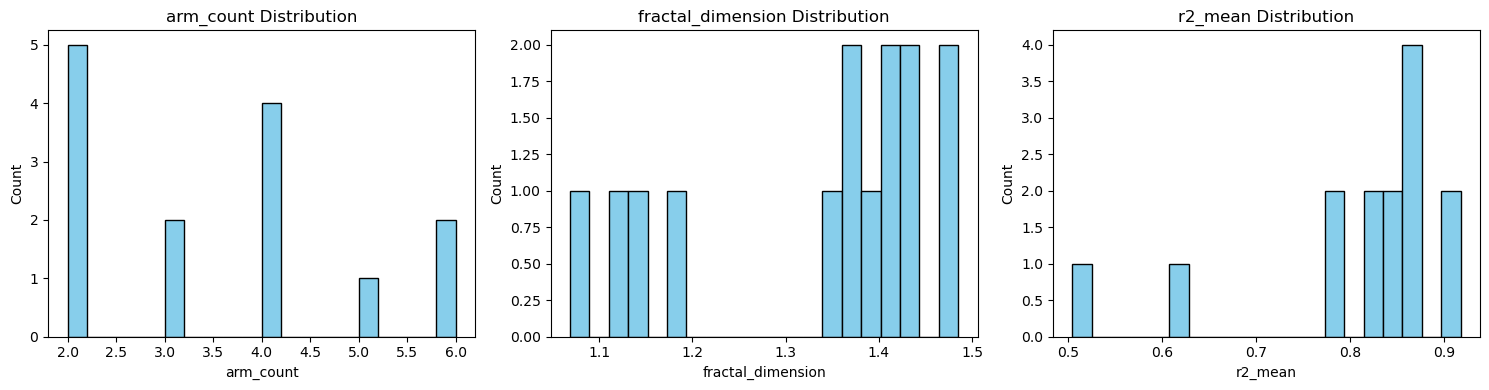

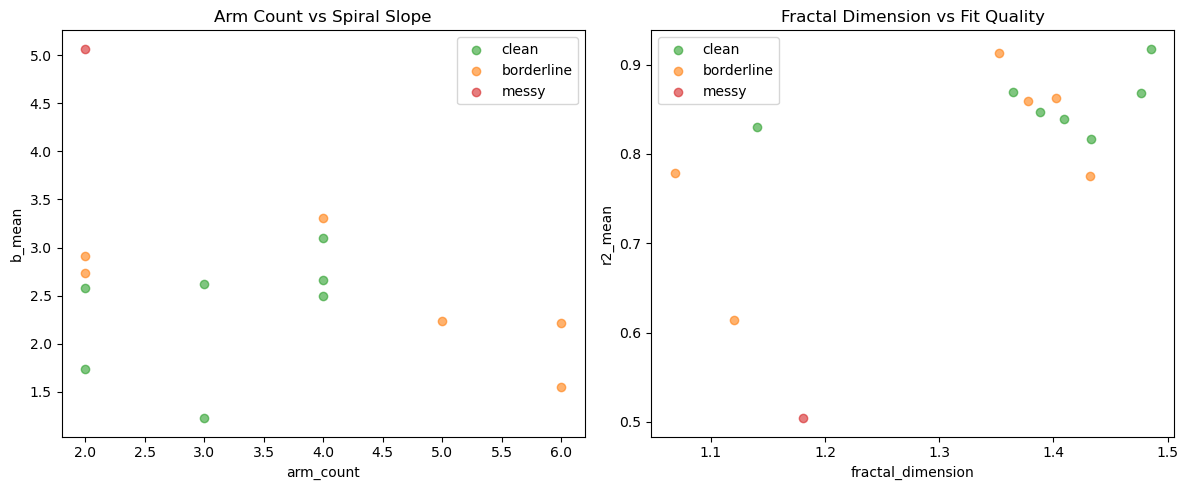

In [3]:
if 'df' in locals():
    color_map = {"clean": "tab:green", "borderline": "tab:orange", "messy": "tab:red"}
    
    # Histograms
    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    
    for i, col in enumerate(["arm_count", "fractal_dimension", "r2_mean"]):
        axes[i].hist(df[col].dropna(), bins=20, color="skyblue", edgecolor="black")
        axes[i].set_title(f"{col} Distribution")
        axes[i].set_xlabel(col)
        axes[i].set_ylabel("Count")
    plt.tight_layout()
    plt.show()
    
    # Scatter Plots
    fig, axes = plt.subplots(1, 2, figsize=(12, 5))
    
    # arm_count vs b_mean
    for label, color in color_map.items():
        subset = df[df["quality_label"] == label]
        axes[0].scatter(subset["arm_count"], subset["b_mean"], c=color, label=label, alpha=0.6)
    axes[0].set_xlabel("arm_count")
    axes[0].set_ylabel("b_mean")
    axes[0].set_title("Arm Count vs Spiral Slope")
    axes[0].legend()
    
    # fractal_dimension vs r2_mean
    for label, color in color_map.items():
        subset = df[df["quality_label"] == label]
        axes[1].scatter(subset["fractal_dimension"], subset["r2_mean"], c=color, label=label, alpha=0.6)
    axes[1].set_xlabel("fractal_dimension")
    axes[1].set_ylabel("r2_mean")
    axes[1].set_title("Fractal Dimension vs Fit Quality")
    axes[1].legend()
    
    plt.tight_layout()
    plt.show()

## 4. Visual Examples: Clean vs Messy

Clean Examples:


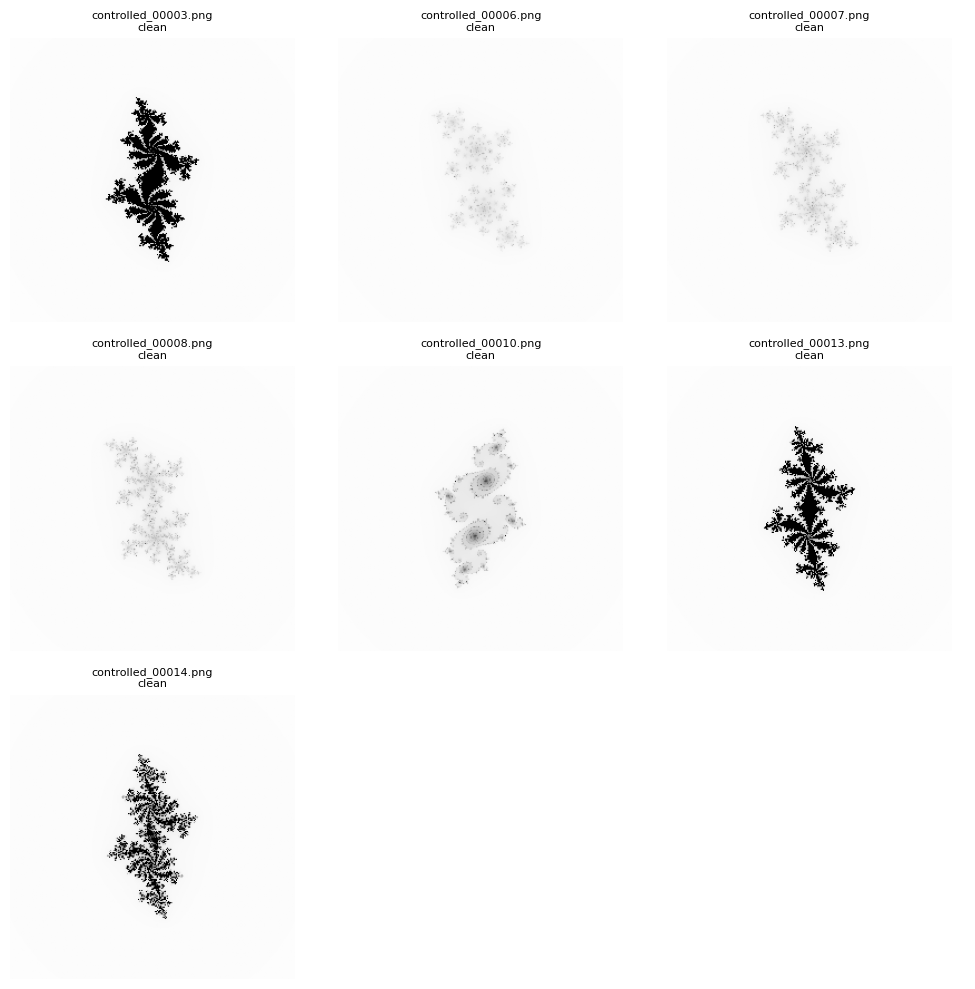

Messy Examples:


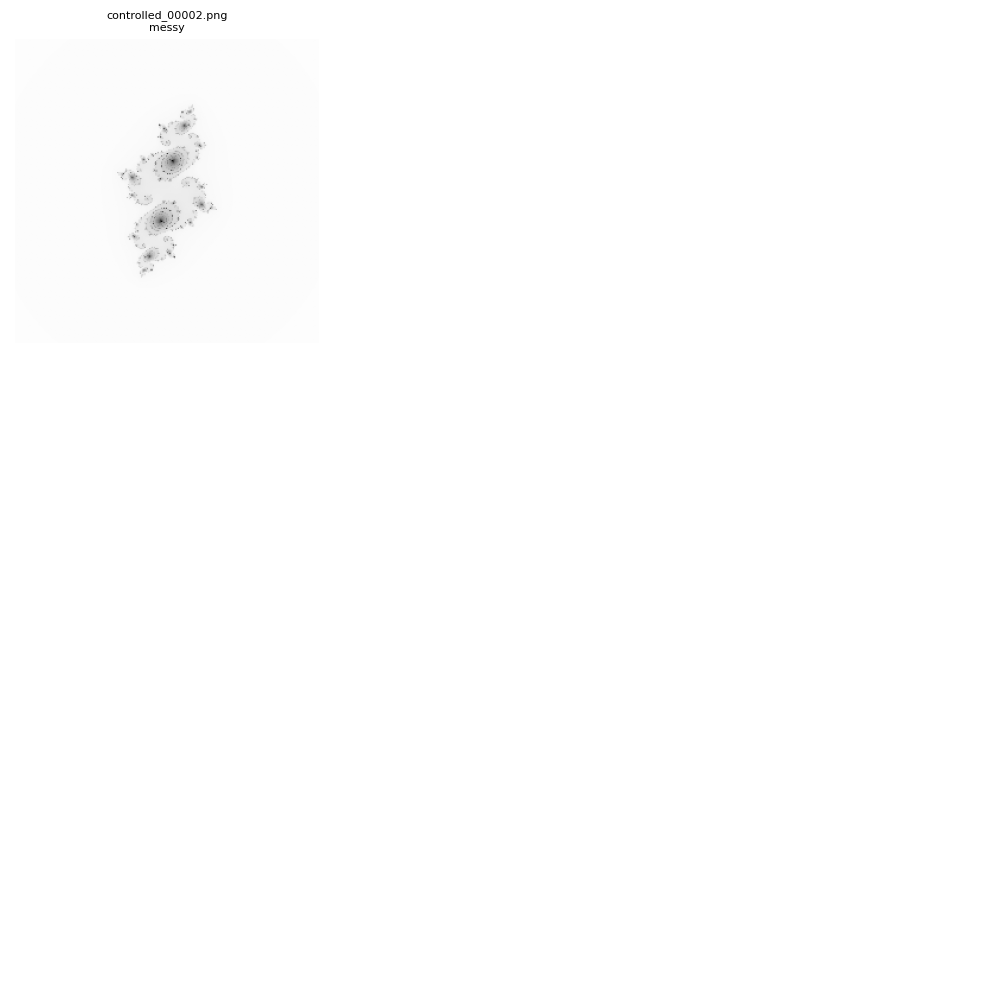

In [4]:
import matplotlib.image as mpimg

def show_grid(df_subset, title_suffix):
    if len(df_subset) == 0:
        print(f"No examples found for {title_suffix}")
        return
        
    n = min(9, len(df_subset))
    rows = 3
    cols = 3
    
    fig, axes = plt.subplots(rows, cols, figsize=(10, 10))
    axes = axes.flatten()
    
    for i in range(n):
        row = df_subset.iloc[i]
        img_name = row["image"]
        
        # Try to find the image
        img_path = repo_root / img_name
        if not img_path.exists():
            # Try sweeps
            img_path = repo_root / "figures" / "sweeps" / Path(img_name).name
        if not img_path.exists():
            # Try best
            img_path = repo_root / "figures" / "best" / Path(img_name).name
            
        if img_path.exists():
            img = mpimg.imread(str(img_path))
            axes[i].imshow(img, cmap="gray")
            axes[i].set_title(f"{Path(img_name).name}\n{title_suffix}", fontsize=8)
            axes[i].axis("off")
        else:
            axes[i].text(0.5, 0.5, "Image not found", ha="center")
            axes[i].axis("off")
            
    # Turn off remaining axes
    for i in range(n, rows*cols):
        axes[i].axis("off")
        
    plt.tight_layout()
    plt.show()

if 'df' in locals():
    clean_examples = df[df["quality_label"] == "clean"].head(9)
    messy_examples = df[df["quality_label"] == "messy"].head(9)
    
    print("Clean Examples:")
    show_grid(clean_examples, "clean")
    
    print("Messy Examples:")
    show_grid(messy_examples, "messy")

## 5. Save Updated Metrics

In [5]:
if 'df' in locals():
    out_path = repo_root / "results" / "spiral_metrics_labeled.csv"
    df.to_csv(out_path, index=False)
    print(f"Saved labeled metrics to {out_path}")
    
    # Also overwrite original if needed, but let's keep it safe for now
    # df.to_csv(metrics_path, index=False)

Saved labeled metrics to /Users/charannagaram/spiral_fractals/results/spiral_metrics_labeled.csv
